# Data Exploration

There are 3 csv files:
1. loan
2. payment
3. clarity_under_writing_variables

<u>Based on my understanding: </u>

__Loan__ has 19 columns that explained the loan application process to payment status of the borrower



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
%matplotlib inline

In [2]:
loan_df = pd.read_csv(r'C:\Users\Teng Li Yuan\DS Assessment\data\data\loan.csv')
pay_df = pd.read_csv(r'C:\Users\Teng Li Yuan\DS Assessment\data\data\payment.csv')
cuv_df = pd.read_csv(r'C:\Users\Teng Li Yuan\DS Assessment\data\data\clarity_underwriting_variables.csv')

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (9,11,12,13,14,15,16,17,18,19,20,21,22,23,25,26,27,28,29,31,32,33,36,37) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Loan


In [3]:
## Converting the application date to datetime format

loan_df['applicationDate'] = pd.to_datetime(loan_df['applicationDate'])
print(f"total unique anon_ssn: {len(loan_df['anon_ssn'].unique())}"   )
print(f"total loan amount: {loan_df['loanAmount'].sum()}")
loan_df.describe()

total unique anon_ssn: 459393
total loan amount: 295913077.25


,apr,nPaidOff,isFunded,loanAmount,originallyScheduledPaymentAmount,leadCost,hasCF
count,573760.000000,577658.000000,577682.000000,575432.000000,577682.000000,577682.000000,577682.000000
mean,553.080972,0.037887,0.067480,514.245084,1428.897209,7.854389,0.619187
std,110.046159,0.333366,0.250852,320.939929,925.009141,12.853451,0.485587
min,0.000000,0.000000,0.000000,0.000000,-816.710000,0.000000,0.000000
25%,490.000000,0.000000,0.000000,350.000000,1023.640000,3.000000,0.000000
50%,590.000000,0.000000,0.000000,500.000000,1245.250000,3.000000,1.000000
75%,601.000000,0.000000,0.000000,500.000000,1615.660000,6.000000,1.000000
max,705.590000,21.000000,1.000000,5000.000000,19963.630000,200.000000,1.000000


Text(0.5, 0, 'Loan Amount')

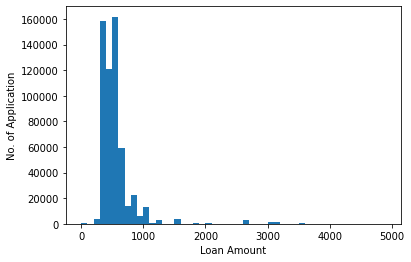

In [4]:
plt.hist(loan_df['loanAmount'], bins=np.arange(0, 5000, 100))  
plt.ylabel('No. of Application')
plt.xlabel('Loan Amount')

In [5]:
## The lead types predominantly byMandatory (82%) or lead (12%).

loan_df['leadType'].value_counts(normalize=True)

bvMandatory      0.822253
lead             0.125801
organic          0.039556
prescreen        0.007816
rc_returning     0.003582
california       0.000829
lionpay          0.000045
repeat           0.000042
instant-offer    0.000038
express          0.000038
Name: leadType, dtype: float64

In [6]:
print(loan_df.groupby('state').count()['isFunded'].sort_values().head(7))
print(loan_df.groupby('state').count()['isFunded'].sort_values().tail(3))

## Finding the state that received the most and least applicantions

state
TX-TEST      1
OH-TEST      1
NY           3
MD           3
ND         207
AK         290
HI         621
Name: isFunded, dtype: int64
state
TX    49729
IL    66710
OH    90496
Name: isFunded, dtype: int64


In [7]:
## Approved rate:
a = (loan_df['approved'] == True).sum() / loan_df['approved'].count()* 100 
print(f"The approval rate is {a:.2f} %")

The approval rate is 6.93 %


#### Loan Application:

There are __577,682__ rows of loan application from unique __45,9393__ users, applied for total of USD approx __0.3B__

Averagely each user applied for __514.24__ USD.


####  Some question that we seek to answer through this loan data set is:
1. What is the average loan amount per person?

   <font color='red'>Averagely each user applied for __514.24__ USD. __75%__ of the applicant applied __500__ USD with min = 0 max = 5000 </font>   
2. What are the top and least 3 state that has the most loan application
    
   <font color='red'> OH, IL, TX and HI, AK, ND </font> 
3. What is the application approved rate? 
    <font color='red'> 6.93% </font> 

# Business Objective:
The objectives is to mitigate the losses on our portforlio of loans. Specifically, we want to predict whether the borrower will repay the loan before the loan approval decision. 


# Project Outline:
1. Data Selection
2. Label the data
3. Feature engineering / Selection
4. Modelling

In [8]:
loan_df[loan_df['approved']==True]['loanStatus'].unique()

array(['Paid Off Loan', 'New Loan', 'Internal Collection',
       'External Collection', 'Returned Item', 'Customer Voided New Loan',
       'Credit Return Void', 'Pending Paid Off', 'Charged Off Paid Off',
       'Settled Bankruptcy', 'Settlement Paid Off', 'Charged Off',
       'CSR Voided New Loan', 'Pending Rescind',
       'Customver Voided New Loan', 'Withdrawn Application',
       'Voided New Loan', 'Settlement Pending Paid Off'], dtype=object)

## 1 & 2. Data Selection +  Label the data

<u>Input data Selection:</u>

Imagine having the loan application on our table, we only have the borrower's information such as the type of payfrequeny, apr, application date, loan amount, state, nPaidOff, leadtype etc. These are the information that our model take in and trying to predict. 

Therefore, our Input data column is the __loan.csv left join with clarity-underwriting variables.csv__. 

We will also be ignoring __payment.csv__, because these contain the 'future' payment record that can be summarised with *loan status* column in loan.csv.


### <u>Label the data</u>

We labelled loan with below loan status as a __Good loan__
1. 'Paid off Loan'
2. 'New Loan'   
3. 'Returned Item'   --  Missed only 1 payment, which can be considered as healthy loan
4. 'Pending Paid Off' 

We labelled loan with below loan status as a __Bad loan__
1. 'Internal Collection'
2. 'External Collection'
3. 'Charged Off Paid Off'
4. 'Settled Bankruptcy'
5. 'Settlement Paid Off'
6. 'Charged Off'
7. 'Settlement Pending Paid Off'

ps: The challenging part is actually to understand the finance jargon and determine whether it should be a good or bad loan

We __removed__ records with below loan status because it was withdrawn or not approved
1. 'Customer Voided New Loan'
2. 'Credit Return Void'
3. 'CSR Voided New Loan'
4. 'Pending Rescind'
5. 'Customver Voided New Loan'
6. 'Withdrawn Application'
7. 'Voided New Loan'

In [9]:
## Remain only the funded_loan

good_loan = ['Paid Off Loan', 'New Loan', 'Returned Item', 'Pending Paid Off']
bad_loan = ['Internal Collection', 'External Collection',  'Charged Off Paid Off', 'Settled Bankruptcy', 'Settlement Paid Off', 'Charged Off', 'Settlement Pending Paid Off']

funded_loan_df = loan_df.loc[loan_df['isFunded']==1]



In [10]:
funded_loan_df.reset_index().head()

,index,loanId,anon_ssn,payFrequency,apr,applicationDate,originated,originatedDate,nPaidOff,approved,isFunded,loanStatus,loanAmount,originallyScheduledPaymentAmount,state,leadType,leadCost,fpStatus,clarityFraudId,hasCF
0,1,LL-I-06644937,464f5d9ae4fa09ece4048d949191865c,B,199.0,2016-01-19 22:07:36.778,True,2016-01-20T15:49:18.846000,0.0,True,1,Paid Off Loan,3000.0,6395.19,CA,prescreen,0,Checked,569eb3a3e4b096699f685d64,1
1,15,LL-I-12263369,accf40708233e8b7d05fcb89d5a9c081,B,475.0,2016-11-28 19:54:22.982,True,2016-11-29T20:30:40.640000,2.0,True,1,New Loan,350.0,893.88,MO,organic,0,Checked,NaN,0
2,33,LL-I-17826953,7529d29c9d943cc55bc71a85d9c6b7a3,W,645.0,2017-03-01 15:55:41.823,True,2017-03-01T16:15:13.016000,0.0,True,1,New Loan,400.0,1364.87,NJ,lead,40,Checked,58b6eef8e4b0b6fca82fd426,1
3,47,LL-I-16519347,bc9fa73468acf18cb968a3a6a3c4697c,S,490.0,2017-01-31 17:48:17.381,True,2017-01-31T18:00:14.520000,2.0,True,1,Paid Off Loan,1250.0,3313.78,MO,organic,0,Checked,58450a15e4b0bb9d6d7344c7,1
4,54,LL-I-11506719,10cefd11d41612b032fd9cd2debe32dc,B,590.0,2016-08-27 09:08:05.442,True,2016-08-29T15:05:04.014000,0.0,True,1,Paid Off Loan,800.0,2432.08,CA,bvMandatory,10,Checked,578f9346e4b0810ad5e7b72e,1


In [11]:
## Left join the loan and clearfraud

loan_cuv_df = pd.merge(funded_loan_df,  cuv_df, left_on = 'clarityFraudId', right_on = 'underwritingid', how = 'left')
loan_cuv_df.head()

,loanId,anon_ssn,payFrequency,apr,applicationDate,originated,originatedDate,nPaidOff,approved,isFunded,...,.underwritingdataclarity.clearfraud.clearfraudidentityverification.phonematchtypedescription,.underwritingdataclarity.clearfraud.clearfraudidentityverification.overallmatchresult,.underwritingdataclarity.clearfraud.clearfraudidentityverification.phonetype,.underwritingdataclarity.clearfraud.clearfraudidentityverification.ssndobreasoncode,.underwritingdataclarity.clearfraud.clearfraudidentityverification.ssnnamereasoncode,.underwritingdataclarity.clearfraud.clearfraudidentityverification.nameaddressreasoncode,.underwritingdataclarity.clearfraud.clearfraudidentityverification.ssndobmatch,.underwritingdataclarity.clearfraud.clearfraudidentityverification.overallmatchreasoncode,clearfraudscore,underwritingid
0,LL-I-06644937,464f5d9ae4fa09ece4048d949191865c,B,199.0,2016-01-19 22:07:36.778,True,2016-01-20T15:49:18.846000,0.0,True,1,...,NaN,partial,NaN,D04,NaN,NaN,invalid,5.0,879.0,569eb3a3e4b096699f685d64
1,LL-I-12263369,accf40708233e8b7d05fcb89d5a9c081,B,475.0,2016-11-28 19:54:22.982,True,2016-11-29T20:30:40.640000,2.0,True,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,LL-I-17826953,7529d29c9d943cc55bc71a85d9c6b7a3,W,645.0,2017-03-01 15:55:41.823,True,2017-03-01T16:15:13.016000,0.0,True,1,...,(U) Unlisted,match,NaN,NaN,NaN,NaN,match,1.0,658.0,58b6eef8e4b0b6fca82fd426
3,LL-I-16519347,bc9fa73468acf18cb968a3a6a3c4697c,S,490.0,2017-01-31 17:48:17.381,True,2017-01-31T18:00:14.520000,2.0,True,1,...,(M) Mobile Phone,partial,NaN,NaN,NaN,A8,match,6.0,835.0,58450a15e4b0bb9d6d7344c7
4,LL-I-11506719,10cefd11d41612b032fd9cd2debe32dc,B,590.0,2016-08-27 09:08:05.442,True,2016-08-29T15:05:04.014000,0.0,True,1,...,(P) Pager,match,NaN,NaN,NaN,NaN,match,1.0,624.0,578f9346e4b0810ad5e7b72e


In [12]:
## Label the data into good or bad loan

loan_cuv_df['Loan type'] = loan_cuv_df['loanStatus'].apply(lambda x: 'Good' if x in good_loan else 'Bad')
loan_cuv_df[['Loan type','loanStatus']].head(10)

,Loan type,loanStatus
0,Good,Paid Off Loan
1,Good,New Loan
2,Good,New Loan
3,Good,Paid Off Loan
4,Good,Paid Off Loan
5,Good,Paid Off Loan
6,Bad,Internal Collection
7,Good,Paid Off Loan
8,Good,New Loan
9,Good,New Loan


In [13]:
# Check if there is any rejected loan after filter by loan status

loan_cuv_df[loan_cuv_df['approved'] == False]


,loanId,anon_ssn,payFrequency,apr,applicationDate,originated,originatedDate,nPaidOff,approved,isFunded,...,.underwritingdataclarity.clearfraud.clearfraudidentityverification.overallmatchresult,.underwritingdataclarity.clearfraud.clearfraudidentityverification.phonetype,.underwritingdataclarity.clearfraud.clearfraudidentityverification.ssndobreasoncode,.underwritingdataclarity.clearfraud.clearfraudidentityverification.ssnnamereasoncode,.underwritingdataclarity.clearfraud.clearfraudidentityverification.nameaddressreasoncode,.underwritingdataclarity.clearfraud.clearfraudidentityverification.ssndobmatch,.underwritingdataclarity.clearfraud.clearfraudidentityverification.overallmatchreasoncode,clearfraudscore,underwritingid,Loan type


In [14]:
## Do some further cleaning
## Drop some unapproved loan that has loan status

loan_cuv_df.drop(  loan_cuv_df[loan_cuv_df['approved'] == False].index, inplace=True  )

In [15]:
## Make sure no unapproved loan

loan_cuv_df[loan_cuv_df['approved'] == False]

,loanId,anon_ssn,payFrequency,apr,applicationDate,originated,originatedDate,nPaidOff,approved,isFunded,...,.underwritingdataclarity.clearfraud.clearfraudidentityverification.overallmatchresult,.underwritingdataclarity.clearfraud.clearfraudidentityverification.phonetype,.underwritingdataclarity.clearfraud.clearfraudidentityverification.ssndobreasoncode,.underwritingdataclarity.clearfraud.clearfraudidentityverification.ssnnamereasoncode,.underwritingdataclarity.clearfraud.clearfraudidentityverification.nameaddressreasoncode,.underwritingdataclarity.clearfraud.clearfraudidentityverification.ssndobmatch,.underwritingdataclarity.clearfraud.clearfraudidentityverification.overallmatchreasoncode,clearfraudscore,underwritingid,Loan type


In [16]:
loan_cuv_df['approved'].unique()

## Ok now our data only has all the approved loan

array([ True])

In [17]:
loan_cuv_df.head()

,loanId,anon_ssn,payFrequency,apr,applicationDate,originated,originatedDate,nPaidOff,approved,isFunded,...,.underwritingdataclarity.clearfraud.clearfraudidentityverification.overallmatchresult,.underwritingdataclarity.clearfraud.clearfraudidentityverification.phonetype,.underwritingdataclarity.clearfraud.clearfraudidentityverification.ssndobreasoncode,.underwritingdataclarity.clearfraud.clearfraudidentityverification.ssnnamereasoncode,.underwritingdataclarity.clearfraud.clearfraudidentityverification.nameaddressreasoncode,.underwritingdataclarity.clearfraud.clearfraudidentityverification.ssndobmatch,.underwritingdataclarity.clearfraud.clearfraudidentityverification.overallmatchreasoncode,clearfraudscore,underwritingid,Loan type
0,LL-I-06644937,464f5d9ae4fa09ece4048d949191865c,B,199.0,2016-01-19 22:07:36.778,True,2016-01-20T15:49:18.846000,0.0,True,1,...,partial,NaN,D04,NaN,NaN,invalid,5.0,879.0,569eb3a3e4b096699f685d64,Good
1,LL-I-12263369,accf40708233e8b7d05fcb89d5a9c081,B,475.0,2016-11-28 19:54:22.982,True,2016-11-29T20:30:40.640000,2.0,True,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Good
2,LL-I-17826953,7529d29c9d943cc55bc71a85d9c6b7a3,W,645.0,2017-03-01 15:55:41.823,True,2017-03-01T16:15:13.016000,0.0,True,1,...,match,NaN,NaN,NaN,NaN,match,1.0,658.0,58b6eef8e4b0b6fca82fd426,Good
3,LL-I-16519347,bc9fa73468acf18cb968a3a6a3c4697c,S,490.0,2017-01-31 17:48:17.381,True,2017-01-31T18:00:14.520000,2.0,True,1,...,partial,NaN,NaN,NaN,A8,match,6.0,835.0,58450a15e4b0bb9d6d7344c7,Good
4,LL-I-11506719,10cefd11d41612b032fd9cd2debe32dc,B,590.0,2016-08-27 09:08:05.442,True,2016-08-29T15:05:04.014000,0.0,True,1,...,match,NaN,NaN,NaN,NaN,match,1.0,624.0,578f9346e4b0810ad5e7b72e,Good


In [20]:
# Fill NA clearfraudscore with -1
loan_cuv_df['clearfraudscore']=loan_cuv_df['clearfraudscore'].fillna(-1)

In [21]:
loan_cuv_df.to_csv("loan_cuv_df.csv")

## 3. Feature Engineering / Selection

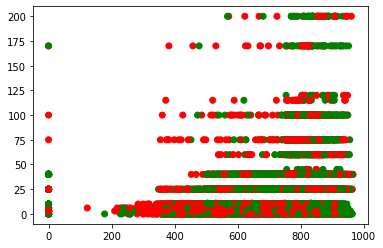

In [22]:
## We try to see if there is a clearfraudscore and a leadcost, will it help to discriminate the good and bad loan

color = {'Good': 'green', 'Bad': 'red' }
has_CF_df = loan_cuv_df[loan_cuv_df['hasCF']==1]
plt.scatter(has_CF_df['clearfraudscore'], has_CF_df['leadCost'], c = has_CF_df['Loan type'].map(color))

## Visually we cant see any useful pattern

In [23]:
# If there is a CFscore, is there a difference in mean between good and bad loan

has_CF_df.groupby('Loan type')['clearfraudscore'].describe()

# Seems bad loan has like lower Clearfraudscore mean

,count,mean,std,min,25%,50%,75%,max
Loan type,,,,,,,,
Bad,15423.0,655.217856,137.152188,-1.0,562.0,660.0,761.0,965.0
Good,16937.0,701.829309,141.492072,-1.0,618.0,722.0,802.0,963.0


In [24]:
# Preliminary, We have selected the below variables to do our classification.
# For now we will ignore the tons clearfraud variables and assume the final clearFraudScore can represent them.
# The bottom set version1 has contain all the available information of the borrower before the loan approval decison
# The data is labelled with good or bad loan type

loan_cuv_df_v1 = loan_cuv_df[['payFrequency', 'apr',  'nPaidOff','loanAmount', 'state', 'leadType','leadCost', 'clearfraudscore', 'Loan type']]
loan_cuv_df_v1.describe()

,apr,nPaidOff,loanAmount,leadCost,clearfraudscore
count,38982.000000,38961.000000,38982.000000,38982.000000,38982.000000
mean,527.410074,0.372218,639.727644,11.921169,563.995844
std,124.604931,1.020026,478.619761,20.203014,286.208775
min,0.000000,0.000000,100.000000,0.000000,-1.000000
25%,449.990000,0.000000,375.000000,0.000000,510.000000
50%,590.000000,0.000000,500.000000,3.000000,651.000000
75%,601.000000,0.000000,700.000000,10.000000,768.000000
max,705.590000,21.000000,4687.000000,200.000000,965.000000


In [25]:
## Just want to confirm the apr with min 0 is not an anomaly
## Probably a zero interest promotion? We will keep it

loan_cuv_df_v1.loc[loan_cuv_df_v1['apr']<20]

,payFrequency,apr,nPaidOff,loanAmount,state,leadType,leadCost,clearfraudscore,Loan type
2191,B,0.0,1.0,600.0,SC,organic,0,-1.0,Bad
18981,B,0.0,0.0,300.0,WI,bvMandatory,3,-1.0,Bad
28945,B,0.0,0.0,800.0,SC,bvMandatory,3,-1.0,Good


In [26]:
loan_cuv_df_v1.head()

,payFrequency,apr,nPaidOff,loanAmount,state,leadType,leadCost,clearfraudscore,Loan type
0,B,199.0,0.0,3000.0,CA,prescreen,0,879.0,Good
1,B,475.0,2.0,350.0,MO,organic,0,-1.0,Good
2,W,645.0,0.0,400.0,NJ,lead,40,658.0,Good
3,S,490.0,2.0,1250.0,MO,organic,0,835.0,Good
4,B,590.0,0.0,800.0,CA,bvMandatory,10,624.0,Good


In [27]:
## Checking is there any Null value

loan_cuv_df_v1[['payFrequency', 'apr', 'loanAmount', 'nPaidOff', 'state', 'leadType','leadCost', 'clearfraudscore', 'Loan type']].isnull().any()

## nPaidOff has Null value

payFrequency       False
apr                False
loanAmount         False
nPaidOff            True
state              False
leadType           False
leadCost           False
clearfraudscore    False
Loan type          False
dtype: bool

In [28]:
loan_cuv_df_v1.loc[loan_cuv_df_v1['nPaidOff'].isnull()]

## About 21 records, we can drop it

,payFrequency,apr,nPaidOff,loanAmount,state,leadType,leadCost,clearfraudscore,Loan type
1543,B,442.89,NaN,1000.0,OH,lead,25,840.0,Bad
3614,B,478.67,NaN,800.0,OH,lead,25,-1.0,Bad
5941,M,478.67,NaN,500.0,OH,lead,25,-1.0,Bad
7385,B,478.67,NaN,500.0,OH,lead,25,-1.0,Bad
7897,B,478.67,NaN,800.0,OH,lead,25,-1.0,Bad
10068,B,29.99,NaN,691.0,GA,lionpay,0,-1.0,Good
10156,S,705.59,NaN,200.0,OH,lead,25,-1.0,Bad
11098,B,442.89,NaN,1000.0,OH,lead,25,-1.0,Bad
11386,B,478.67,NaN,800.0,OH,lead,25,-1.0,Bad
12106,B,478.67,NaN,600.0,OH,lead,10,-1.0,Bad


In [29]:
loan_cuv_df_v1 = loan_cuv_df_v1.dropna(subset = ['nPaidOff'])

In [30]:
loan_cuv_df_v1.dtypes

payFrequency        object
apr                float64
nPaidOff           float64
loanAmount         float64
state               object
leadType            object
leadCost             int64
clearfraudscore    float64
Loan type           object
dtype: object

In [31]:
# Save csv

loan_cuv_df_v1.to_csv('loan_cuv_df_v1.csv')

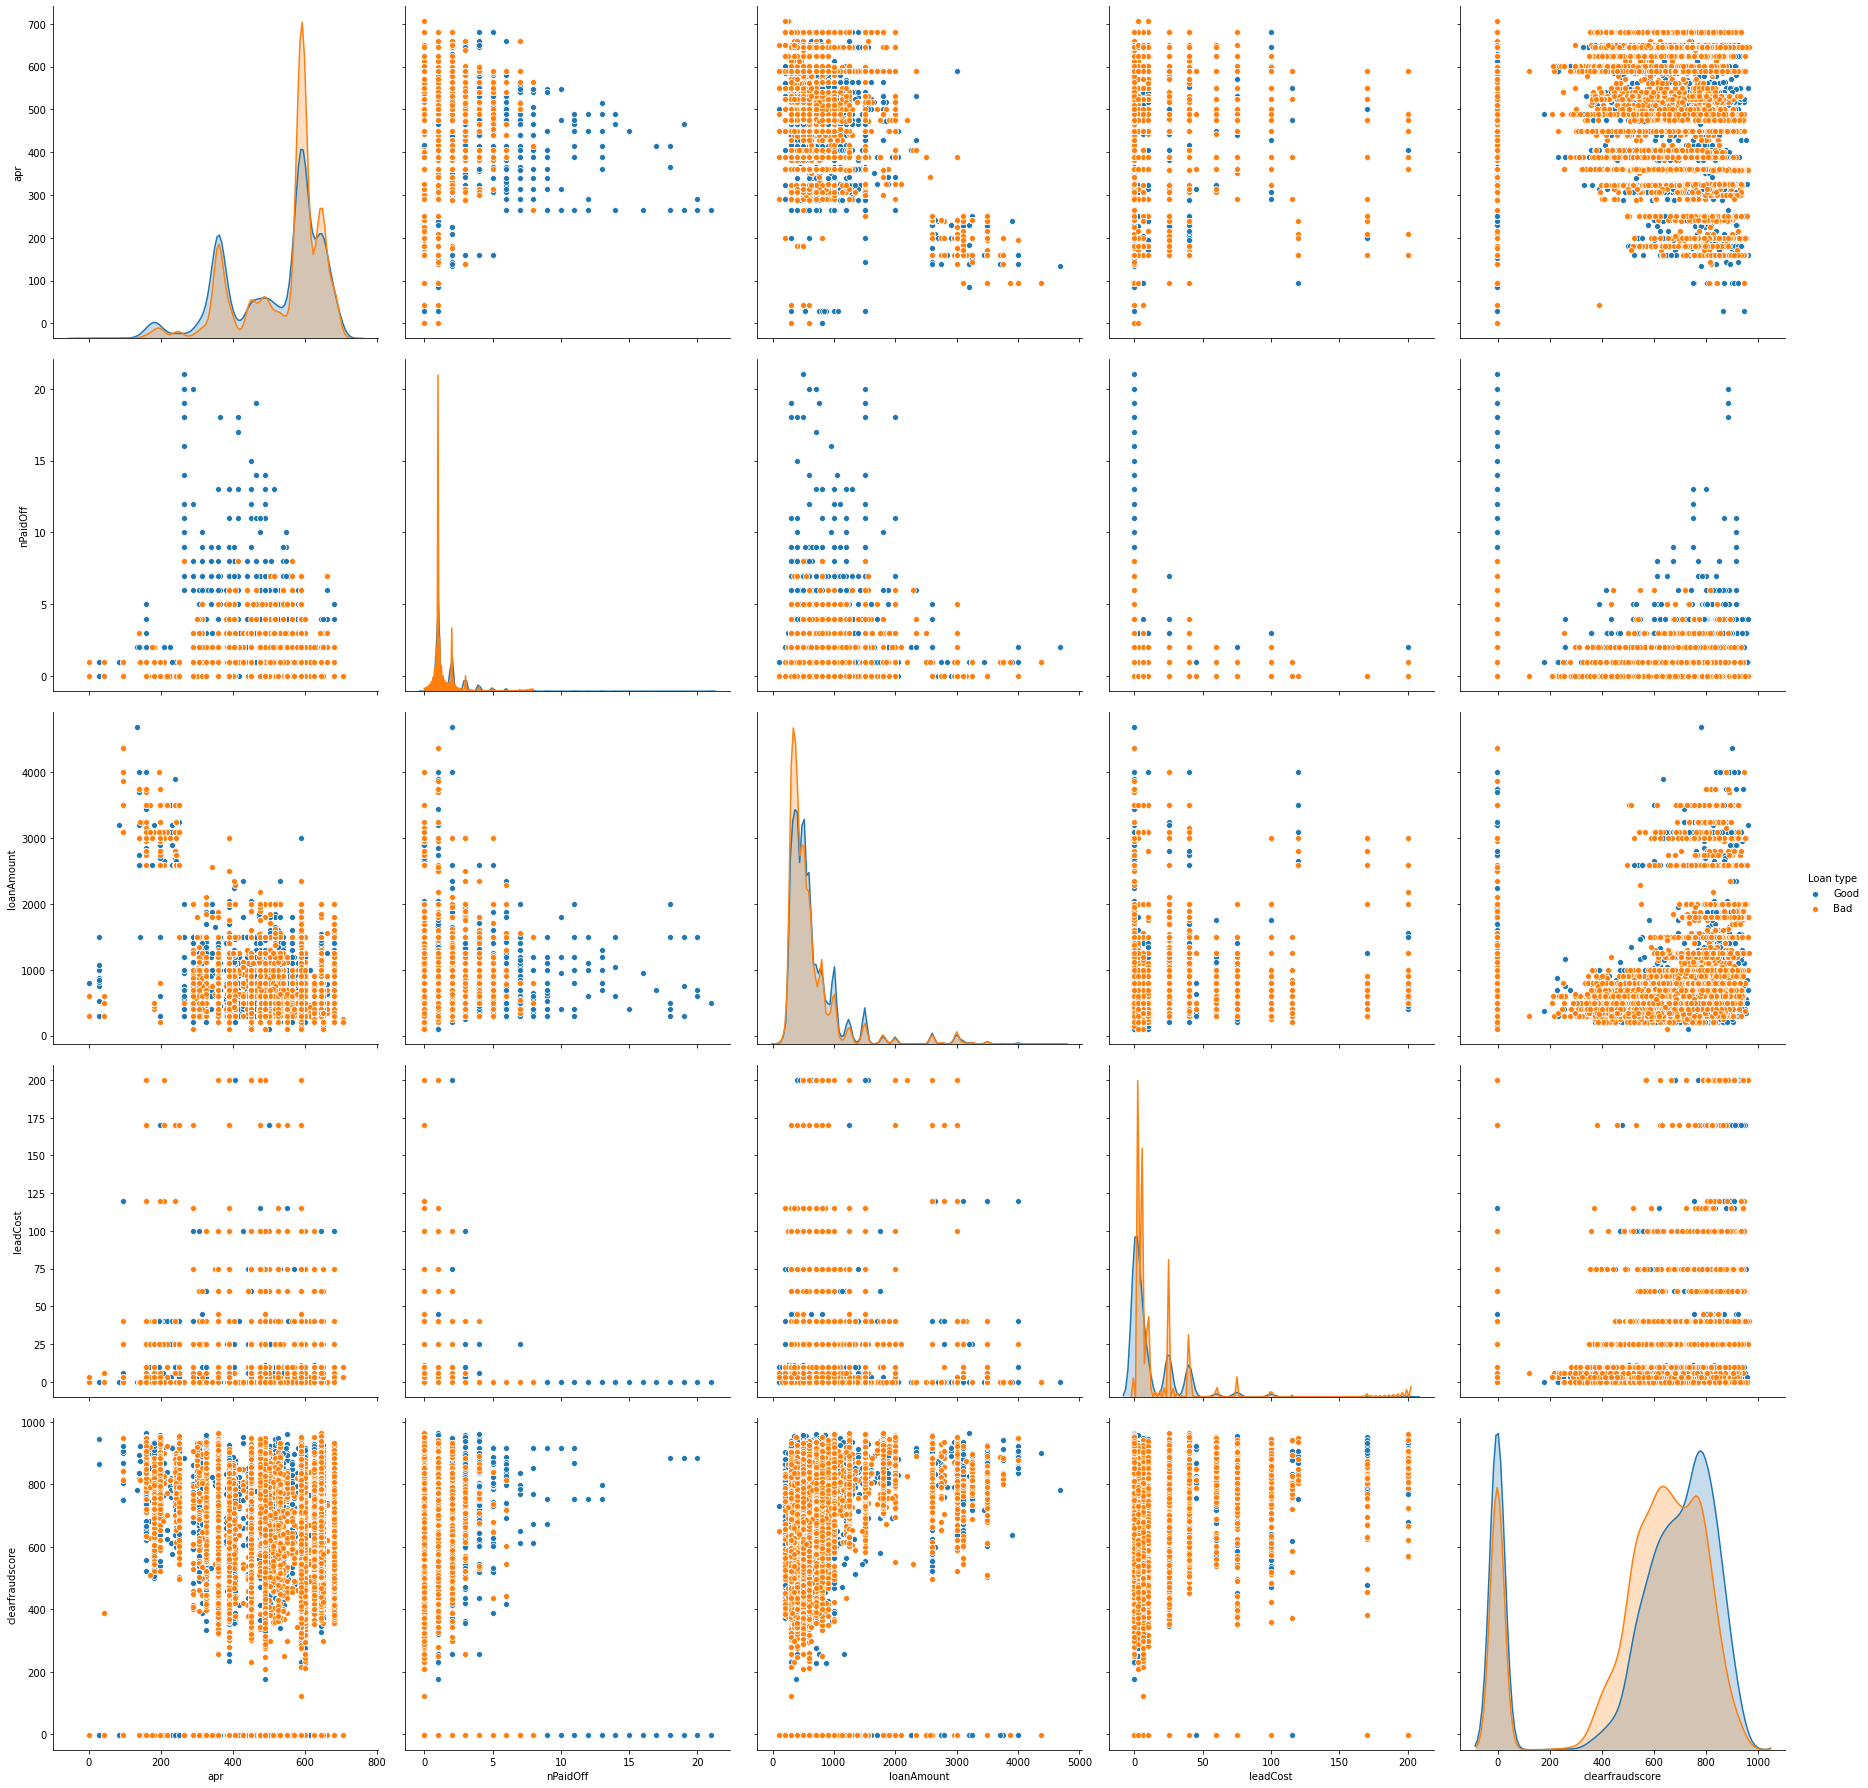

In [32]:
# Lets plot the pairplot to see is there any significant pattern to discriminate the good and bad loan

sns.pairplot( loan_cuv_df_v1, hue='Loan type', height = 5, )

By looking at the pairplot, Some of the "Good" and "Bad" loan are linearly separable.

There are some pattern in this pairplot that hint us in feature selection
The *clearfraudscore* plot shows different distribution of the group.
The -1 at clearfraud score are those without the CF record
High nPaidOff has more Good loan

__Let us now try out with Weka__

The figure below shows the distribution of the data.
There are slightly more "Good" than "Bad" (21k vs 18k), slightly imbalance but still okay.
The baseline model (ZeroR) by blindly predicting with majority classes is 53%


When we use Weka to inspect the variables, *clearfraudscore*, *nPaidOff* and *leadType* suggest these two variables might be useful in discriminating the good and bad loan.
![title](weka_distribution.png)

So I did a little test and error with classifier in the WEKA,
found that by using *npaidoff*, *leadtype* and *clearfraudscore* alone as input variables and J48 decision tree, with 10-fold cross validation can give a 63.4% accuracy / Weighted F1 score of 0.63. 

Using additional variables such as leadcost, loan amount, state, apr etc does not improved the performance. Thus, we will focus only with these three variables.

### Decision Tree
The figure below shows the decision tree, 
Lead type was placed at the root of the tree indicates this variables has a higher information gain.


![title](weka_decision_tree.png)

Next, lets try to implement this into python.

# Modeling

We will be splitting the data into training: testing = 0.9:0.1

For 10-fold cross-validation, no splitting are required.

<u>The above ML algoritms were implemented using SK learn package:</u>
1. Baseline (Zero-R)  
2. Decision Tree      
3. Random Forest      
4. LDA                
5. SVM                
6. Naive-Bayes        
7. Logistic Regression
8. KNN                
9. SVM                
10. XGBoost           

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree

# Unlike WEKA, SK learn decision tree can only handle numerical value
# so we have to one-hot-encode the categorical 'leadtype'

all_inputs =loan_cuv_df_v1 [['clearfraudscore', 'nPaidOff']].join(pd.get_dummies(loan_cuv_df_v1['leadType']))
all_classes = loan_cuv_df_v1['Loan type'].values



# train test split 0.9:0.1, random state = 1 to fix the split to make it reproducable
train_inputs, test_inputs, train_classes, test_classes = train_test_split(all_inputs, all_classes, train_size=0.9, random_state=1)

In [34]:
loan_cuv_df_v1 [['clearfraudscore', 'nPaidOff']].join(pd.get_dummies(loan_cuv_df_v1['leadType'])).describe()

# Looks good to me, no missing value...

,clearfraudscore,nPaidOff,bvMandatory,california,express,instant-offer,lead,lionpay,organic,prescreen,rc_returning,repeat
count,38961.000000,38961.000000,38961.000000,38961.000000,38961.000000,38961.000000,38961.000000,38961.000000,38961.000000,38961.000000,38961.000000,38961.000000
mean,564.256641,0.372218,0.425271,0.001258,0.000411,0.000231,0.296553,0.000180,0.195016,0.033546,0.047304,0.000231
std,286.006358,1.020026,0.494390,0.035442,0.020261,0.015197,0.456744,0.013403,0.396218,0.180061,0.212290,0.015197
min,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,510.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,651.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,768.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,965.000000,21.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [35]:
## Implement Decision Tree with train test split
## Decision tree

dtc = DecisionTreeClassifier(criterion= 'entropy')
dtc.fit(train_inputs, train_classes)
round(dtc.score(test_inputs, test_classes),2)

# 0.59, gini gave us the similar accuracy
# We will use accuracy as the evaluation metric since it's a balance class

0.6

In [36]:
## We can fine tune with lower max_depth.
## Alternatively we can also use gridsearchcv to fine tune the max_depth parameter

dtc = DecisionTreeClassifier(criterion= 'entropy', max_depth = 5).fit(train_inputs, train_classes)
round(dtc.score(test_inputs, test_classes),2)

## We tried with max_depth = 3, this is to limit the level of leaf branch by pruning and reduce overfitting.
## Accuracy of 64%, still higher than the baseline model of 53%

0.64

[Text(555.6750000000001, 498.3, 'X[2] <= 0.5\nentropy = 0.996\nsamples = 35064\nvalue = [16287, 18777]'),
 Text(292.95000000000005, 407.70000000000005, 'X[1] <= 1.5\nentropy = 0.954\nsamples = 20187\nvalue = [7564, 12623]'),
 Text(148.8, 317.1, 'X[1] <= 0.5\nentropy = 0.974\nsamples = 17354\nvalue = [7025, 10329]'),
 Text(74.4, 226.5, 'X[0] <= 515.5\nentropy = 0.986\nsamples = 12928\nvalue = [5562, 7366]'),
 Text(37.2, 135.89999999999998, 'X[9] <= 0.5\nentropy = 0.947\nsamples = 831\nvalue = [527, 304]'),
 Text(18.6, 45.299999999999955, 'entropy = 0.952\nsamples = 811\nvalue = [509, 302]'),
 Text(55.800000000000004, 45.299999999999955, 'entropy = 0.469\nsamples = 20\nvalue = [18, 2]'),
 Text(111.60000000000001, 135.89999999999998, 'X[0] <= 806.5\nentropy = 0.98\nsamples = 12097\nvalue = [5035, 7062]'),
 Text(93.0, 45.299999999999955, 'entropy = 0.991\nsamples = 8202\nvalue = [3631, 4571]'),
 Text(130.20000000000002, 45.299999999999955, 'entropy = 0.943\nsamples = 3895\nvalue = [1404, 2

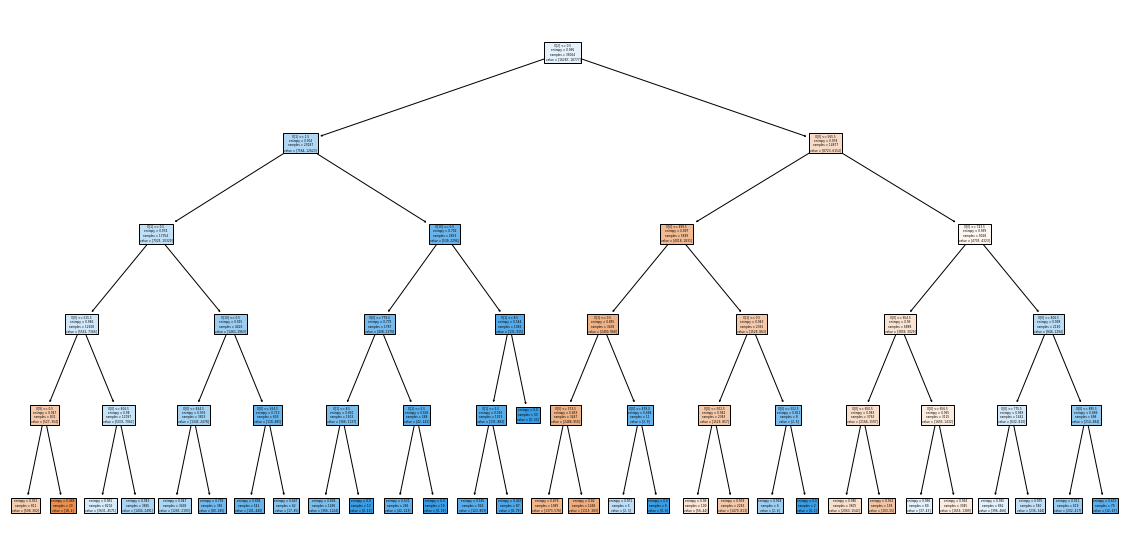

In [37]:
# Lets visualise the Decision Tree

plt.figure(figsize=(20,10))
plot_tree(dtc, filled=True)

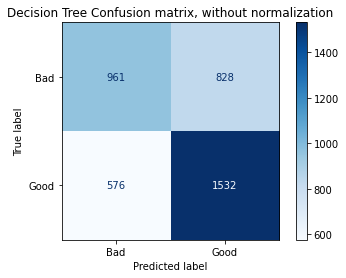

In [38]:
## Visualise the decision tree confusion metric

disp = metrics.plot_confusion_matrix(dtc, test_inputs, test_classes,                                 
                                 cmap=plt.cm.Blues,
                                 normalize=None)
disp.ax_.set_title('Decision Tree Confusion matrix, without normalization');

In [39]:
## Random Forest with Cross Validation

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

rfc = RandomForestClassifier(max_depth=3, random_state=1)
rfc.fit(train_inputs, train_classes)
print(f"random forest with train_test_split accuracy is : {rfc.score(test_inputs, test_classes)}")

round(cross_val_score(RandomForestClassifier(max_depth=3, random_state=1), all_inputs, all_classes, cv=10).mean(), 2)

# Using random forest can reduce the high variance error in a single decision tree. The result are still the same
# Using 10-fold cross validation we get about 61% to 63% accuracy

random forest with train_test_split accuracy is : 0.6356171413908135


0.62

In [40]:
## Well since our data is already in numerical value, lets try LDA

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

LDA = LinearDiscriminantAnalysis()
round(cross_val_score(LDA, all_inputs, all_classes, cv=10).mean(), 2)

# About 61% accuracy

0.61

In [41]:
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

In [42]:
gnb = GaussianNB()
cv = cross_val_score(gnb,all_inputs,all_classes,cv=10).mean()
round(cv,2)

0.53

In [43]:
lr = LogisticRegression(max_iter = 2000)
cv = cross_val_score(lr,all_inputs,all_classes,cv=10).mean()
round(cv,2)

0.61

In [44]:
knn = KNeighborsClassifier()
cv = cross_val_score(knn,all_inputs,all_classes,cv=10).mean()
round(cv,2)

0.58

In [45]:
svc = SVC(probability = True)
cv = cross_val_score(svc,all_inputs,all_classes,cv=10).mean()
round(cv,2)

0.59

In [46]:
from xgboost import XGBClassifier
xgb = XGBClassifier(random_state =1)
cv = cross_val_score(xgb,all_inputs,all_classes,cv=10).mean()
round(cv,2)

0.62

## Cross-Validation Result:

1. Baseline (Zero-R)  : 53%
2. Random Forest      : __62%___
3. LDA                : 61%
4. SVM                : __61%__
5. Naive-Bayes        : 53%
6. Logistic Regression: __61%__
7. KNN                : 58%
8. SVM                : 59%
9. XGBoost            : __62%__

## Lets try to improve by ensemble model
The highest accuracy is so far 62%.
We will pick the four highest model to input into ensemble model, i.e. RF, SVM, LR, XGBoost

In [47]:
# Lets try to improve by ensemble model
from sklearn.ensemble import VotingClassifier
voting_clf = VotingClassifier(estimators = [('rf',rfc),('lr',lr),('svc',svc),('xgb',xgb)], voting = 'hard') 
cv = cross_val_score(voting_clf,all_inputs,all_classes,cv=10).mean()

In [48]:
print(cv)

# The model slightly improved to 63%
# This is by 10 CV

0.628192018659117


# Some thought:

The base model in the ensemble can be further improved with gridsearchcv, but it will be taking a lot of time.

Also, there are about 50+ clearfraud variables which we did not use in classfication. 
Mainly because we dont want to have a high dimension data and we assume that the clearfraudscore is informative enough.